## Feature selection
Train every model without columns that where rated unimportant by feature important test in main. Feature selection might not work for our dataset, as the features rated unimportant changed a lot for each model and small parameters changes. 

## Testing different classification models
As first approach to learning, we tried different models.  
We used a grid search to compare different classifiers as well as their parameters. We improved the code throughout the process and ended up with a quite comprehensive grid, that helped us sort aut, which classifier might be the best for our data and goal.



### Preprocessing
Before we did that however, we started by preprocessing the Data.
First, we imported the Data. There is a smaller Dataset with around 10% included in the Data, that we decided to use for the research process. (So we had more reasonable processing times)

Afterwards, we prepared the Data and encoded it, using a OneHot Encoder as well as a MinMaxScaler.


In [9]:
# For installation, uncomment the following installation instructions:
# !pip install pandas numpy seaborn matplotlib scikit-learn imbalanced-learn

# importing libraries
# some utiity Librarys
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

# main ML Library is scikit-learn
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import make_scorer, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator

# Imbalanced-learn is used for Sampling
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [10]:
# For a start, we imported a dedicated small sample (10%) of the Dataset, to have reasonable processing times
bank_data = pd.read_csv("Data/bank-additional/bank-additional/bank-additional.csv", delimiter=";") #10 % of examples

bank_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [11]:
# Preprocessing of the target data
bank_target = bank_data['y']
bank_data = bank_data.drop(columns=['y', 'duration', 'emp.var.rate', 'previous']) 

label = LabelEncoder()
bank_target = label.fit_transform(bank_target)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'campaign', 'pdays', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])

### Dummy classifier for performance measuring:  
We added an AlwaysYes and an AlwaysNo classifier

In [12]:
class DummyYesClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.ones((len(X), ), dtype=bool)
    def predict_proba(self, X):
        return np.ones((len(X), 2))
    
class DummyNoClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), ), dtype=bool)
    def predict_proba(self, X):
        return np.zeros((len(X), 2))

### Pipelines:
We prepared some pipleines, to be able to do the preprocessing dynamically within the Cross-Validation Grid search. 

In [13]:
# decision tree
dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', DecisionTreeClassifier())])

# random forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', RandomForestClassifier())])

# k nearest neighbours
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', KNeighborsClassifier())])

# multinomial naive bayes
mnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', MultinomialNB())])

# gaussian naive bayes
gnb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', GaussianNB())])

# neural Network, MLP classifier
nn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler(random_state=42)),
                              ('classifier', MLPClassifier())])

### Grid Search Parameters:
As next step, we set the paramters that we wanted to try for the models tested in the CV Grid Search

In [14]:
dt_param_grid =  { 'classifier__criterion':['gini','entropy'],
                   'classifier__max_depth': np.arange(3, 30),
                   'classifier__random_state': [42]}

rf_param_grid =  {'classifier__n_estimators': [50, 100, 200, 500],
                  'classifier__max_features': ['sqrt','log2'], 
                  'classifier__max_depth' : [4,5,6,7,8,10,12,18,24],
                  'classifier__criterion' :['gini', 'entropy'],
                  'classifier__random_state': [42]}

knn_param_grid = {'classifier__n_neighbors': [3,5,10,15,20,25,30,40,50],
                  'classifier__weights': ['uniform', 'distance'],
                  'classifier__metric': ['euclidean', 'manhattan']}

mnb_param_grid = {'classifier__alpha': [0.5, 1.0, 1.5, 2.0],
                  'classifier__fit_prior': [True, False]}

gnb_param_grid = {'classifier__var_smoothing': np.logspace(0,-9, num=100)}

nn_param_grid = {'classifier__max_iter': [100, 250, 500],
                 'classifier__hidden_layer_sizes': [(50,50,50), (100,100,100)],
                 'classifier__activation': ['tanh', 'relu'],
                 'classifier__solver': ['sgd', 'adam'],
                 'classifier__alpha': [0.005, 0.05],
                 'classifier__learning_rate': ['constant','adaptive'],
                 'balancing__replacement': [True, False],
                  'classifier__random_state': [42]}

### Cost considerations
We choose the potential cost of the model as key metric/scorer for the grid search, to maximize the potential utility.

We thought about potential cost for each potential prediction outcome:  

- Predicting a subscription that happens (`1`, `1`) results in a benefit of 300 units. This reflects the profit from the actual subscription after deducting resource expenses.

- Predicting a non-subscription when the person subscribes (`0`, `1`) incurs a cost of 250 units, indicating a missed profit opportunity due to an incorrect prediction, the opportunity cost. We set that cost, to incentivise the model to predict subscriptions.  

- Predicting a subscription that doesn't happen (`1`, `0`) incurs a cost of 40 units, for the resources spent on marketing to a non-subscriber.

- Predicting a non-subscription that holds true (`0`, `0`) has a cost of 1, indicating cost for running the model.


#### Cost Matrix:
| Predict\Actual  | Subscribe (1) | Not Subscribe (0)    |
|-----------------|---------------|----------------------|
| Subscribe (1)   | (-) 300 (Benefit)| 40 (Cost: Marketing) |
| Not Subscribe (0)| 250 (Cost: Lost Deal) | 0.001 (Cost: Computing)|

#### Cost function
From the cost Matrix, we formed a corresponsing cost function.

In [15]:
def cost_function(y_true, y_pred): 
    cm = confusion_matrix(y_true, y_pred, labels=label_order)    
    return (- cm[1][1] * 300 + cm[0][1] * 40 
            + cm[1][0] * 250 + cm[0][0] * 0.001)

scorer = make_scorer(cost_function, greater_is_better=False)

### Predict:
After these pre considerations, we did a large grid-search to compare both, multiple estimators as well as multiple parameters.

AttributeError: 'DataFrame' object has no attribute 'toArray'

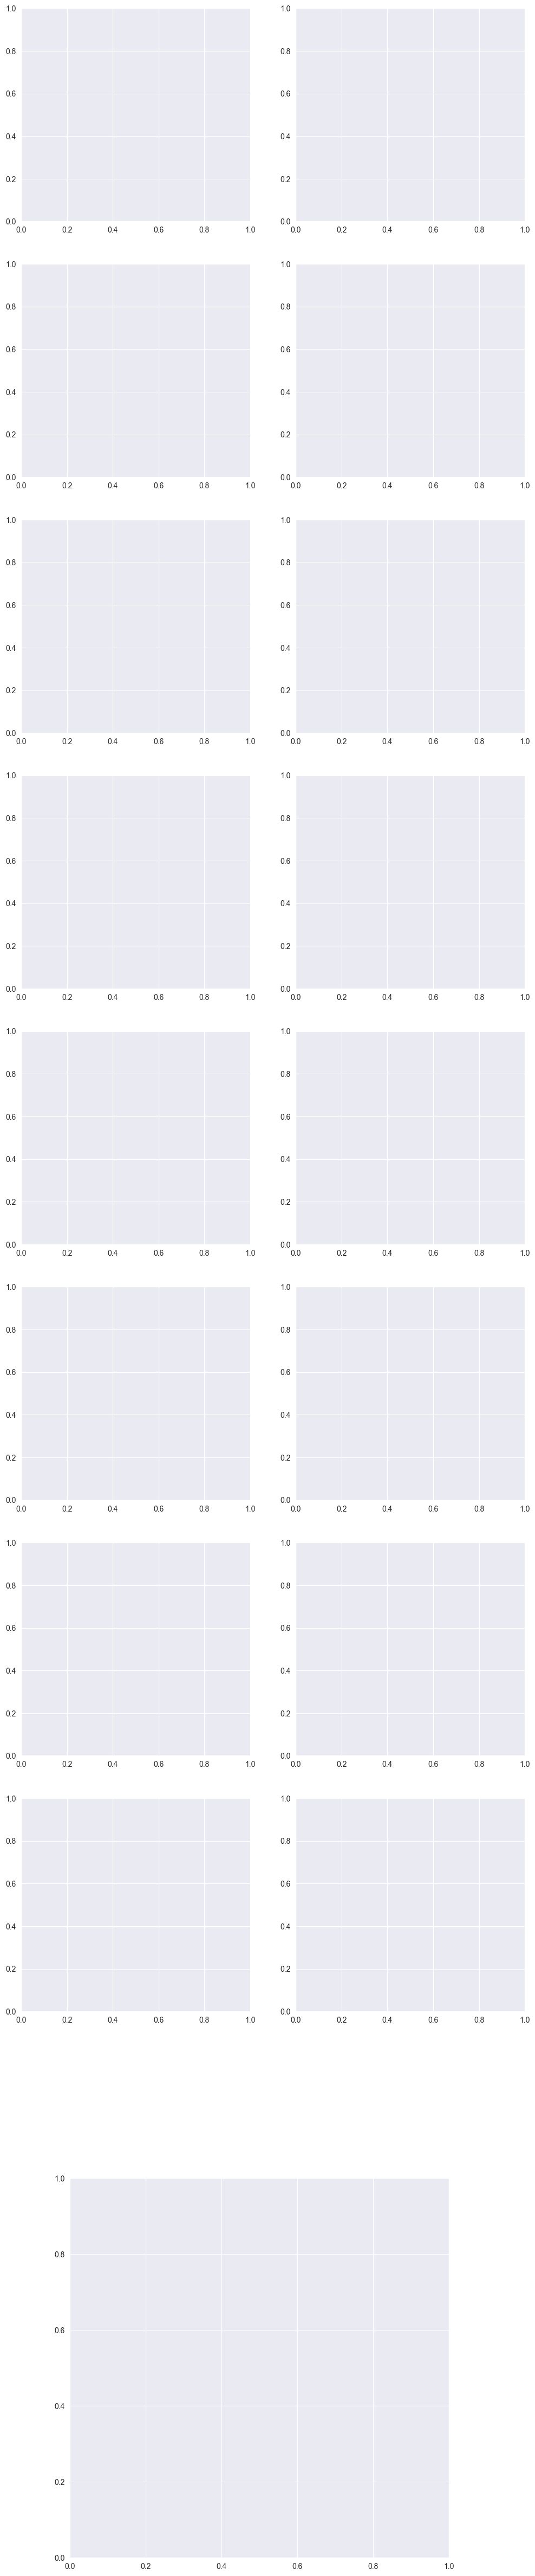

In [16]:
# list with classifier's and grid search parameters
classifiers = [('DecisionTree', dt_pipeline, dt_param_grid),
               ('RandomForest', rf_pipeline, rf_param_grid),
               ('KNN', knn_pipeline, knn_param_grid),
               ('MultinomialNB', mnb_pipeline, mnb_param_grid),
               ('GaussianNB', gnb_pipeline, gnb_param_grid),
               ('NeuralNet', nn_pipeline, nn_param_grid),
               ('AlwaysYes', DummyYesClassifier(), {})
            #    ('AlwaysNo', DummyNoClassifier(), {})
               ]


# Initialize lists to store performances
names = []
accuracies = []
recalls = []
costs = []

fig, axs = plt.subplots(len(classifiers)+1, 2, figsize=(12, (len(classifiers)+1) * 6))
ax_r = fig.add_axes([0.2, -0.1, 7/fig.get_figwidth(), 7/fig.get_figheight()]) 


# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.2, random_state=42)

# Loop over the classifiers
for i, (name, pipeline, param_grid) in enumerate(classifiers):
    # Grid search with parameter grid and cost function
    grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
    grid_search.fit(bank_data_train, bank_target_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Get the best parameters
    best_param = grid_search.best_params_
    
    # Make predictions with the best model
    prediction = best_model.predict(bank_data_test)

    # ROC curve prep
    # Calculate probabilities for the positive class
    probs = best_model.predict_proba(bank_data_test)[:, 1]
    
    # Calculate the ROC
    fpr, tpr, thresholds = roc_curve(bank_target_test, probs)
    
    # Calculate the AUC
    roc_auc = roc_auc_score(bank_target_test, probs)
    
    # Plot the ROC curve
    axs[i, 0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[i, 0].plot([0, 1], [0, 1], 'k--')
    axs[i, 0].set_xlim([0.0, 1.0])
    axs[i, 0].set_ylim([0.0, 1.05])
    axs[i, 0].set_xlabel('False Positive Rate')
    axs[i, 0].set_ylabel('True Positive Rate')
    axs[i, 0].set_title('ROC for {}'.format(name))
    axs[i, 0].legend(loc="lower right")
    #and add to sum roc plot
    ax_r.plot(fpr, tpr, label= name + ' (area = %0.2f)' % roc_auc)

    # Calculate acc, recall, cost
    cm = confusion_matrix(bank_target_test, prediction)
    acc = accuracy_score(bank_target_test, prediction)
    recall = recall_score(bank_target_test, prediction) #yes recall
    cost = cost_function(bank_target_test, prediction)

    # Append them to list
    names.append(name)
    accuracies.append(acc)
    costs.append(cost)
    recalls.append(recall)

    # Plot Confusion Matrix for each classifier
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i, 1], xticklabels=label_names, yticklabels=label_names)
    axs[i, 1].set_title('{} Confusion Matrix'.format(name))
    axs[i, 1].set_xlabel('Predicted label')
    axs[i, 1].set_ylabel('True label')

    axs[i, 1].text(1.5, 0.9, "Best {} Classifier with parameters\n".format(name) + textwrap.fill(str(best_param), width=70) + ": \nAccuracy of {}, recall of {} \n and cost {}".format(acc, recall, cost), horizontalalignment='left', verticalalignment='top', transform=axs[i, 1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    axs[i, 1].text(1.5, 0.5, "Classification Report:\n\n{}".format(classification_report(bank_target_test, prediction, target_names=label_names, zero_division=0), width=70), horizontalalignment='left', verticalalignment='top', transform=axs[i, 1].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))


# Plotting comparison

# Subplot for accuracy
axs[len(classifiers), 0].plot(names, accuracies, marker='o', label="Accuracy")
axs[len(classifiers), 0].plot(names, recalls, marker='o', label="Recall")
axs[len(classifiers), 0].set_title('Metrics Comparision')
axs[len(classifiers), 0].set_ylabel('Measurement')
axs[len(classifiers), 0].legend()
axs[len(classifiers), 0].set_ylim([0,1])
axs[len(classifiers), 0].tick_params(axis='x', rotation=60) # rotates x-axis labels 45 degrees

# Subplot for cost
axs[len(classifiers), 1].bar(names, costs)
axs[len(classifiers), 1].set_title('Cost comparison')
axs[len(classifiers), 1].set_ylabel('Cost')
axs[len(classifiers), 1].tick_params(axis='x', rotation=60, )  # rotates x-axis labels 45 degrees

#Subplot with all roc curves
ax_r.plot([0, 1], [0, 1], 'k--')
ax_r.set_xlim([0.0, 1.0])
ax_r.set_ylim([0.0, 1.05])
ax_r.set_xlabel('False Positive Rate')
ax_r.set_ylabel('True Positive Rate')
ax_r.set_title('ROC Comparison')
ax_r.legend(loc="lower right")

plt.show()

In [ ]:
# we separated the trivial solution with no and have anly calcualted the cost here:

no = DummyNoClassifier()
no.fit(bank_data_train, bank_target_train)
prediction = no.predict(bank_data_test)

# Calculate acc, recall, cost
cost = cost_function(bank_target_test, prediction)

print("Trivial Solution \"Always No\" with cost {}".format(cost))
print("Classification Report:")
print(classification_report(bank_target_test, prediction, target_names=label_names, zero_division=0))

### Findings
We found the Random Forest to be the most promising model.  
The cost was the best, the recall, which we also considered important was the best and the accuracy was decent. It also had the largest area under the curve. The Deision Tree apeared to be slightly better some times but varied greatly for different seeds. The neural net was another good model, it had a slightly higher accuracy. However it was more complex and as it didn't optimize as well on the cost scaler, it had worse costs and also a lower recall. The Neural Net also had siginifcantly longer fitting times, even though we only used the small sample datset yet.

#### Cost remarks
We used the cost as key metric. The "lost deal" part of the cost matix is however a fictional cost, whch is important to note. However it is important to be included in the scorer, to incentivice prediciting deals.
As result, both trivial solutions, the Yes and No trivial solution incure positiv costs. Especially for the "Always No" solution (that we didnt add into the comparison graphs for better readability) the real costs would be 0. However there is a lot of opportunity lost in that case, what results in the high cost.  


## Trying feature selection
As one next Step we tried feature selection. We identified some potentially unnecessary features and tried to get better results by only using relevant features for training.
For this procedure, we created the seperate [Feature selection Notebook](main_with_feature_selection.ipynb)  



## Further optimization of Random Forest
The main next step however was, to optimize the random forest.  
We furhter optimized the hyperparamters by running a more targeted grid search which also contained more parameters. We also checked on the sampling.

In [ ]:
#extending param grid for RF
param_grid = {
    'balancing': [RandomOverSampler(), RandomUnderSampler()],
    'classifier__n_estimators': [50, 100, 200, 300, 400],
    'classifier__max_features': ['sqrt', 'log2'],
   'classifier__max_depth': [4,5,6,7,8,10,12,18,24,30, None],
#    'classifier__min_samples_split': [2, 5, 10],
#    'classifier__min_samples_leaf': [1, 2, 4],
   'classifier__bootstrap': [True, False],
   'classifier__criterion': ['gini', 'entropy'],
   'classifier__random_state': [42]
}


# split into test and training data
bank_data_train, bank_data_test, bank_target_train, bank_target_test = train_test_split(bank_data, bank_target, test_size=0.3, random_state=42)

# Grid search with parameter grid and cost function
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=10, scoring=scorer, n_jobs=-1)
grid_search.fit(bank_data_train, bank_target_train)

# Get the best model
best_model = grid_search.best_estimator_

# Get the best parameters
best_param = grid_search.best_params_

# Make predictions with the best model
prediction = best_model.predict(bank_data_test)

# Calculate probabilities for the positive class
probs = best_model.predict_proba(bank_data_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_test, probs)

# Calculate accuracy and cost
cm = confusion_matrix(bank_target_test, prediction)
acc = accuracy_score(bank_target_test, prediction)
recall = recall_score(bank_target_test, prediction) #yes recall
cost = cost_function(bank_target_test, prediction)

# Prepare Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC for RandomForest')
axs[0].legend(loc="lower right")


# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=label_names, yticklabels=label_names)
axs[1].set_title('RandomForest Confusion Matrix')
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')

plt.show()

print("Best Random Forest Classifier with parameters".format(name) + str(best_param) + ": \nAccuracy of {}, recall of {} and cost {}\n".format(acc, recall, cost))
print("Classification Report:\n\n{}".format(classification_report(bank_target_test, prediction, target_names=label_names)))


### Training most promissing Model on big Dataset

Afterwards, we fitted the most promissing model (with the most promissing hyperparamters) on the big dataset.  
For this, we conducted all steps again, including data import, preprocessing etc...  

In [ ]:
#load full datast
bank_data_full = pd.read_csv("Data/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";") 

# Preprocessing of the target data
bank_target_f = bank_data_full['y']
bank_data_f = bank_data_full.drop(columns = ['y', 'duration']) 

label = LabelEncoder()
bank_target_f = label.fit_transform(bank_target_f)
label_names=['no','yes'] # 0 = no, 1 = yes
label_order=label.transform(label_names)

preprocessor = ColumnTransformer(
    transformers=[
        # MinMaxScaler for numerical columns
        ('scaler', preprocessing.MinMaxScaler(), 
            ['age', 'campaign', 'pdays', 'previous', 
            'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',  
            'euribor3m', 'nr.employed']),
        # OneHotEncoder for categorical columns
        ('encoder', preprocessing.OneHotEncoder(handle_unknown='ignore'), 
            ['job','marital','education','default','housing',
             'loan','contact','month','day_of_week','poutcome'])])

# creating a new pipeline
new_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('balancing', RandomUnderSampler()),
                              ('classifier', RandomForestClassifier(
                                  bootstrap=True,
                                  criterion='entropy', 
                                  max_depth=5, 
                                  max_features='sqrt', 
                                  n_estimators=300
                              ))])

# split into test and training data
bank_data_f_train, bank_data_f_test, bank_target_f_train, bank_target_f_test = train_test_split(bank_data_f, bank_target_f, test_size=0.2, random_state=42)

# Create and fit model
new_pipeline.fit(bank_data_f_train, bank_target_f_train)

# Make predictions
prediction = new_pipeline.predict(bank_data_f_test)

# Calculate probabilities for the positive class
probs = new_pipeline.predict_proba(bank_data_f_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(bank_target_f_test, probs)

# Calculate the AUC
roc_auc = roc_auc_score(bank_target_f_test, probs)

# Calculate accuracy and cost
cm = confusion_matrix(bank_target_f_test, prediction)
acc = accuracy_score(bank_target_f_test, prediction)
recall = recall_score(bank_target_f_test, prediction) #yes recall
cost = cost_function(bank_target_f_test, prediction)

# Prepare Plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ROC curve
axs[0].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC for RandomForest')
axs[0].legend(loc="lower right")


# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1], xticklabels=label_names, yticklabels=label_names)
axs[1].set_title('RandomForest Confusion Matrix')
axs[1].set_xlabel('Predicted label')
axs[1].set_ylabel('True label')

plt.show()

print("Best Random Forest Classifier with parameters".format(name) + str(best_param) + ": \nAccuracy of {}, recall of {} and cost {}\n".format(acc, recall, cost))
print("Classification Report:\n\n{}".format(classification_report(bank_target_f_test, prediction, target_names=label_names)))


#### Final training on whole dataset
As a last step, we trained the model on the whole dataset.

In [ ]:
# Create and fit model
new_pipeline.fit(bank_data_f, bank_target_f)